<a href="https://colab.research.google.com/github/isismeira/identificacao_melanoma_cnns/blob/main/melanoma_revoc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pré-processamento

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os, shutil

!rm -rf /content/train /content/test  # limpa se já existir
shutil.copytree('/content/drive/MyDrive/melanoma/train', '/content/train')
shutil.copytree('/content/drive/MyDrive/melanoma/test', '/content/test')

train_dir = '/content/train'
test_dir = '/content/test'

# limpa possíveis subpastas ocultas
for pasta in os.listdir(train_dir):
    caminho = os.path.join(train_dir, pasta)
    if pasta.startswith('.') and os.path.isdir(caminho):
        shutil.rmtree(caminho)
        print(f"Removido: {caminho}")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

AUGMENTATION = True

if AUGMENTATION:
    train_datagen = ImageDataGenerator( # treino com augmentation
        rescale=1./255,
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.8, 1.2]
    )
else:
    train_datagen = ImageDataGenerator( # treino sem augmentation
        rescale=1./255,
        validation_split=0.2
    )

# validação (sem augmentation)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# testes (sem augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# geradores
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    seed=SEED
)

val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    seed=SEED
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print("Classes detectadas:", train_generator.class_indices)


Found 7684 images belonging to 2 classes.
Found 1921 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Classes detectadas: {'benign': 0, 'malignant': 1}


Observando as imagens após pré-processamento...

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_imagens(generator):
  imagens, labels = next(generator)
  # Mostra as 9 primeiras imagens com suas classes
  plt.figure(figsize=(10, 10))
  for i in range(9):
      plt.subplot(3, 3, i+1)
      plt.imshow(imagens[i])
      plt.title(f'Classe: {"malignant" if labels[i] else "benign"}')
      plt.axis('off')
  plt.tight_layout()
  plt.show()

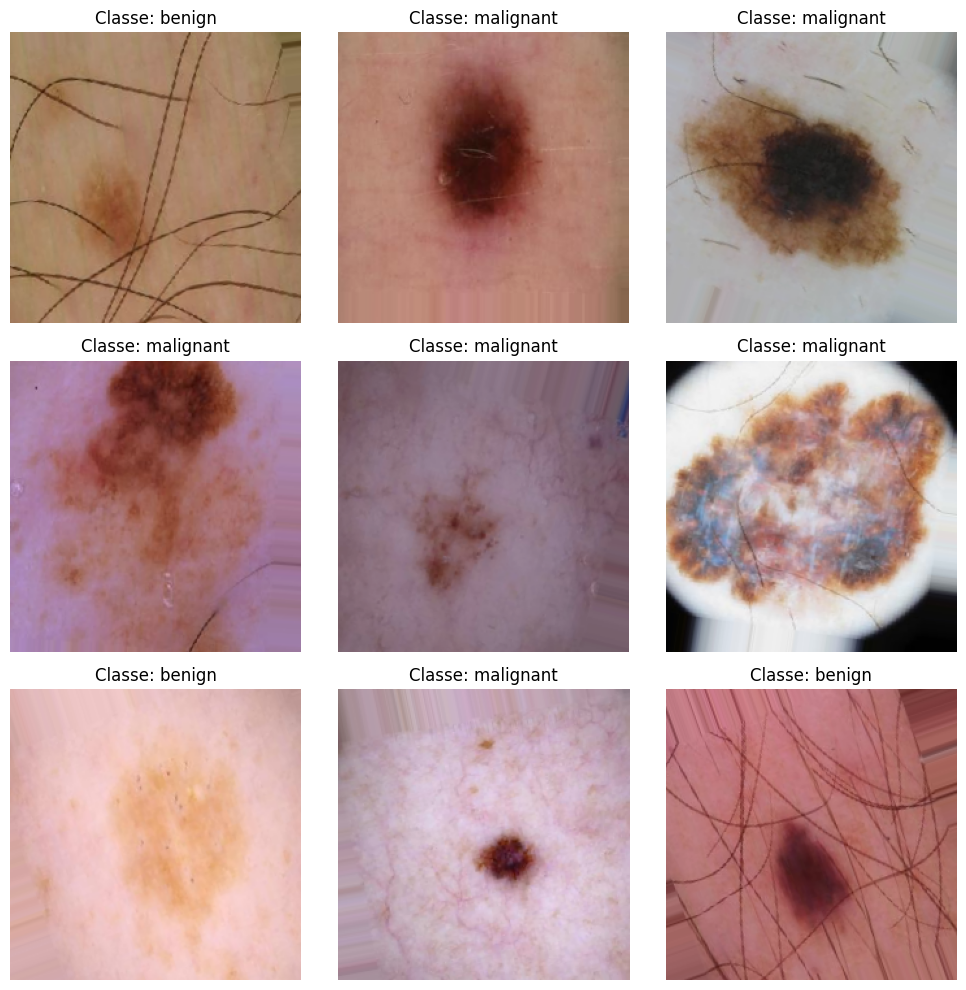

In [ ]:
plot_imagens(train_generator) # imagens do conjunto de treino

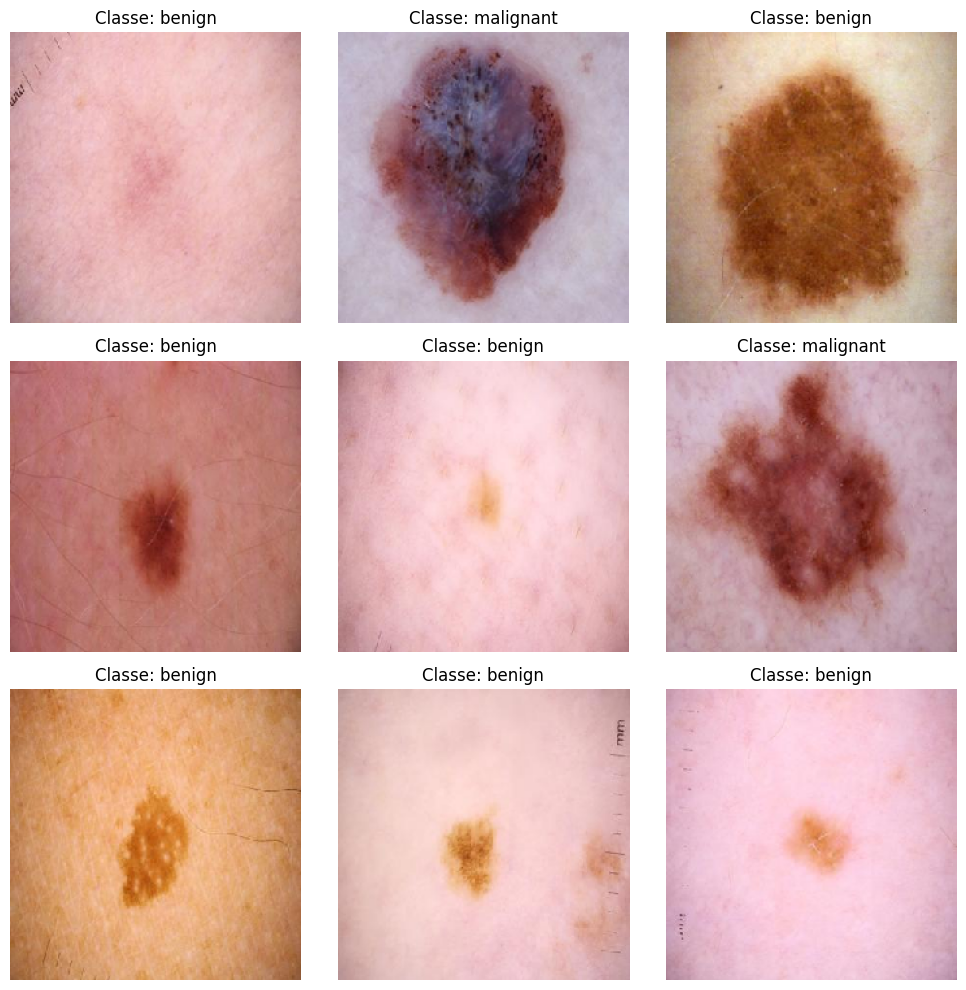

In [ ]:
plot_imagens(val_generator) # imagens do conjunto de validação

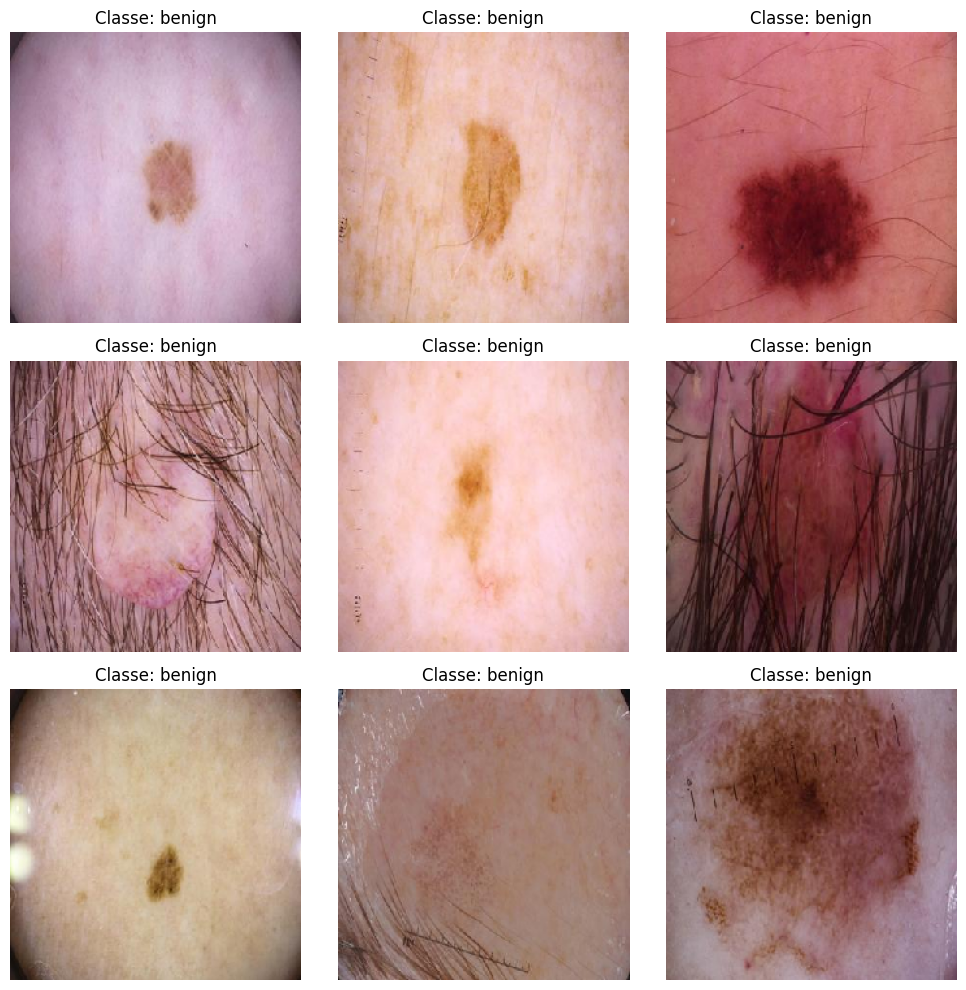

In [ ]:
plot_imagens(test_generator) # imagens do conjunto de teste

## Modelo CNN simples (personalizado)

### Arquitetura do modelo

In [ ]:
modelo_custom = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


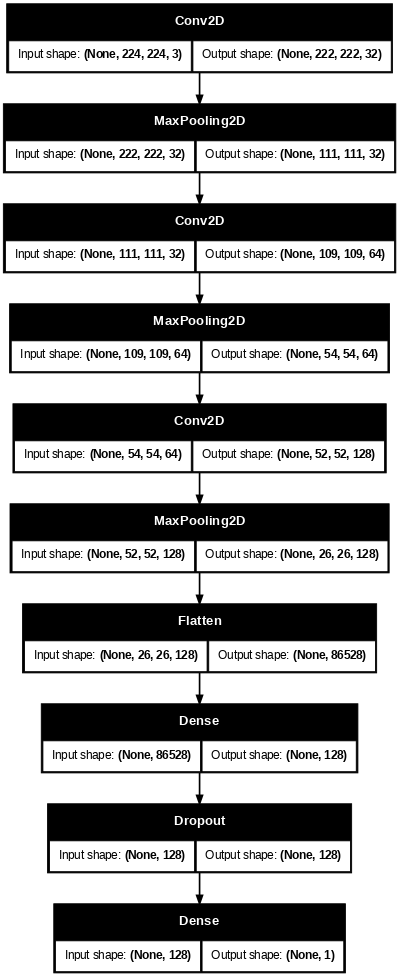

In [ ]:
tf.keras.utils.plot_model(modelo_custom, "arquitetura_do_modelo_custom.png", show_shapes=True, dpi=60)

### Compilação

In [ ]:
from tensorflow.keras.metrics import Precision, Recall # para utilizar as métricas de precisão e revocação

modelo_custom.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

Em aplicações médicas, revocação (recall) é frequentemente mais importante que precisão, pois é melhor ter falsos positivos (benignos classificados como melanoma) do que falsos negativos (melanomas não detectados)

Para resolver isso, é importante usar pesos de classe (class_weight) para penalizar mais erros na classe 1

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# atribuir pesos às classes (class_weight) para informar que erros na classe "maligna" (1) são mais graves.

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weight_dict = dict(enumerate(class_weights))
print("Pesos das classes:", class_weight_dict)


Pesos das classes: {0: np.float64(0.9605), 1: np.float64(1.0428881650380022)}


### Treinando e avaliando o modelo

In [ ]:
historico_custom = modelo_custom.fit(
    train_generator,
    validation_data=val_generator,
    epochs = 10,
    class_weight=class_weight_dict
)

Epoch 1/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 116s 462ms/step - accuracy: 0.8621 - loss: 0.3439 - precision_1: 0.8869 - recall_1: 0.8149 - val_accuracy: 0.8771 - val_loss: 0.2927 - val_precision_1: 0.8932 - val_recall_1: 0.8447
Epoch 2/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 112s 466ms/step - accuracy: 0.8714 - loss: 0.3201 - precision_1: 0.8929 - recall_1: 0.8300 - val_accuracy: 0.8751 - val_loss: 0.2888 - val_precision_1: 0.9158 - val_recall_1: 0.8143
Epoch 3/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 109s 452ms/step - accuracy: 0.8655 - loss: 0.3143 - precision_1: 0.9038 - recall_1: 0.8079 - val_accuracy: 0.8818 - val_loss: 0.3090 - val_precision_1: 0.8747 - val_recall_1: 0.8795
Epoch 4/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 108s 446ms/step - accuracy: 0.8686 - loss: 0.3249 - precision_1: 0.8971 - recall_1: 0.8200 - val_accuracy: 0.8824 - val_loss: 0.2793 - val_precision_1: 0.9162 - val_recall_1: 0.8306
Epoch 5/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 109s 454ms/step - accuracy: 0.8600 - loss: 0.3257 - precision_1: 0.8883 

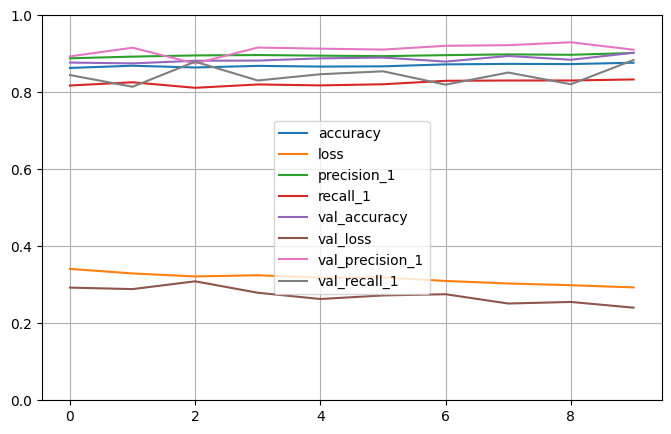

In [ ]:
import pandas as pd

pd.DataFrame(historico_custom.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

Procurando um bom limiar para maximizar o recall da classe maligna...

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step


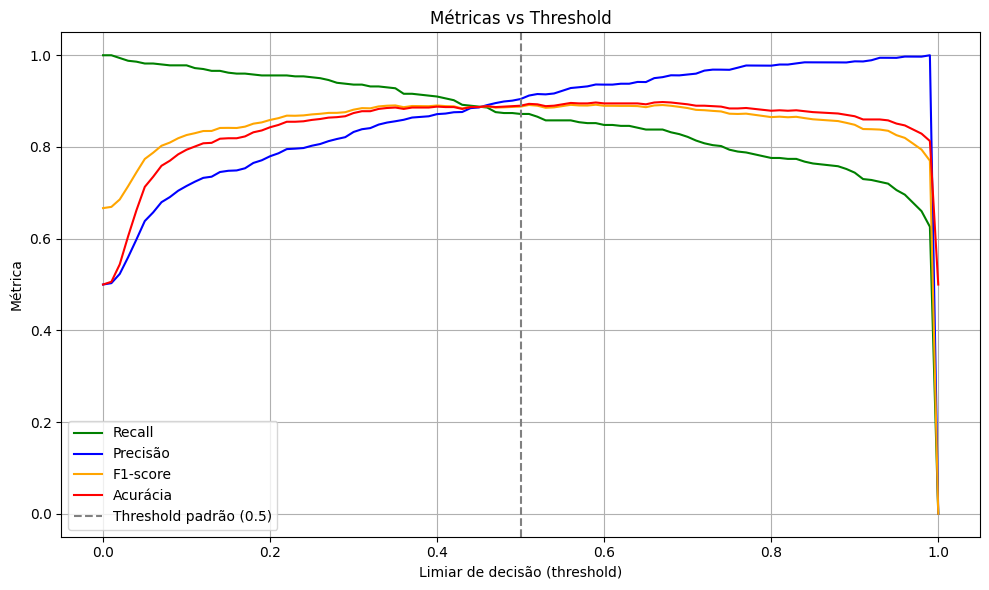

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# prever as probabilidades
y_probs = modelo_custom.predict(test_generator)
y_true = test_generator.classes  # labels reais

# avaliar as métricas para vários limiares
thresholds = np.linspace(0, 1, 101)
precisions = []
recalls = []
f1s = []
accuracies = []

for thresh in thresholds:
    y_pred = (y_probs > thresh).astype(int).flatten()

    precisions.append(precision_score(y_true, y_pred, zero_division=0))
    recalls.append(recall_score(y_true, y_pred))
    f1s.append(f1_score(y_true, y_pred))
    accuracies.append(accuracy_score(y_true, y_pred))

# plotar o gráfico
plt.figure(figsize=(10, 6))
plt.plot(thresholds, recalls, label="Recall", color='green')
plt.plot(thresholds, precisions, label="Precisão", color='blue')
plt.plot(thresholds, f1s, label="F1-score", color='orange')
plt.plot(thresholds, accuracies, label="Acurácia", color='red')
plt.axvline(0.5, color='gray', linestyle='--', label='Threshold padrão (0.5)')
plt.xlabel("Limiar de decisão (threshold)")
plt.ylabel("Métrica")
plt.title("Métricas vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

y_pred_probs = modelo_custom.predict(test_generator)
y_pred = (y_pred_probs > 0.4).astype("int").flatten()  # use 0.4 ou menor

print(classification_report(test_generator.classes, y_pred))

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       500
           1       0.87      0.91      0.89       500

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



In [ ]:
from sklearn.metrics import accuracy_score
print("Acurácia final:", accuracy_score(test_generator.classes, y_pred))

Acurácia final: 0.888


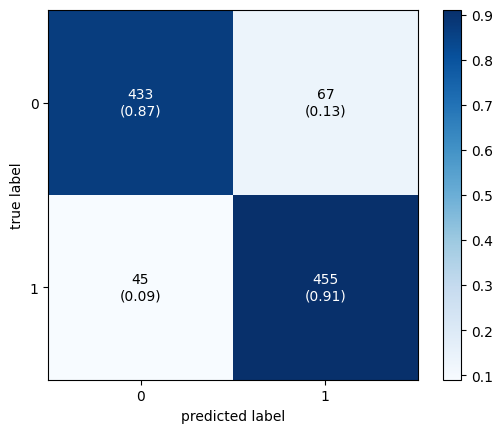

In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

confusao = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(conf_mat=confusao,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()